# Using Seisbench Pytorch Phasenet model without using *annotate*

This note book shows how to use the pytorch neural network model that is at the heart of the Seisbench implementation of Phasenet.

Using the `annotate` function from the model will break long traces into multiple chuncks and run phasnet on each chunk independently. However, the underlying phasenet model built in pytorch can operate on arbitrary-length traces and is much faster.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seisbench.models as sbm
import torch

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

In [71]:
# Normalization from original phasenet implementation
from scipy.interpolate import interp1d
def normalize_batch(data, window=3000):
    """
    data: nsta, nt, nch
    """
    shift = window // 2
    data = data.swapaxes(1,2)
    nsta, nt, nch = data.shape

    # std in slide windows
    data_pad = np.pad(data, ((0, 0), (window // 2, window // 2), (0, 0)), mode="reflect")
    t = np.arange(0, nt, shift, dtype="int")
    std = np.zeros([nsta, len(t) + 1, nch])
    mean = np.zeros([nsta, len(t) + 1, nch])
    for i in range(1, len(t)):
        std[:, i, :] = np.std(data_pad[:, i * shift : i * shift + window, :], axis=1)
        mean[:, i, :] = np.mean(data_pad[:, i * shift : i * shift + window, :], axis=1)

    t = np.append(t, nt)
    # std[:, -1, :] = np.std(data_pad[:, -window:, :], axis=1)
    # mean[:, -1, :] = np.mean(data_pad[:, -window:, :], axis=1)
    std[:, -1, :], mean[:, -1, :] = std[:, -2, :], mean[:, -2, :]
    std[:, 0, :], mean[:, 0, :] = std[:, 1, :], mean[:, 1, :]
    std[std == 0] = 1

    # ## normalize data with interplated std
    t_interp = np.arange(nt, dtype="int")
    std_interp = interp1d(t, std, axis=1, kind="slinear")(t_interp)
    mean_interp = interp1d(t, mean, axis=1, kind="slinear")(t_interp)
    data = (data - mean_interp) / std_interp

    return data.swapaxes(1,2)

Load phasenet model with original parameters

In [2]:
pnmodel = sbm.PhaseNet.from_pretrained("original")

Download sample seismic data

In [72]:
client = Client("GFZ")

t = UTCDateTime("2007/01/02 05:48:50")
stream = client.get_waveforms(
    network="CX",
    station="PB01",
    location="*",
    channel="HH?",
    starttime=t-5,
    endtime=t+72
)

# normalize
data = np.stack([x.data for x in stream])[np.newaxis,:,:]
data = normalize_batch(data).squeeze()
for i,normed_trace in enumerate(data):
    stream[i].data = normed_trace

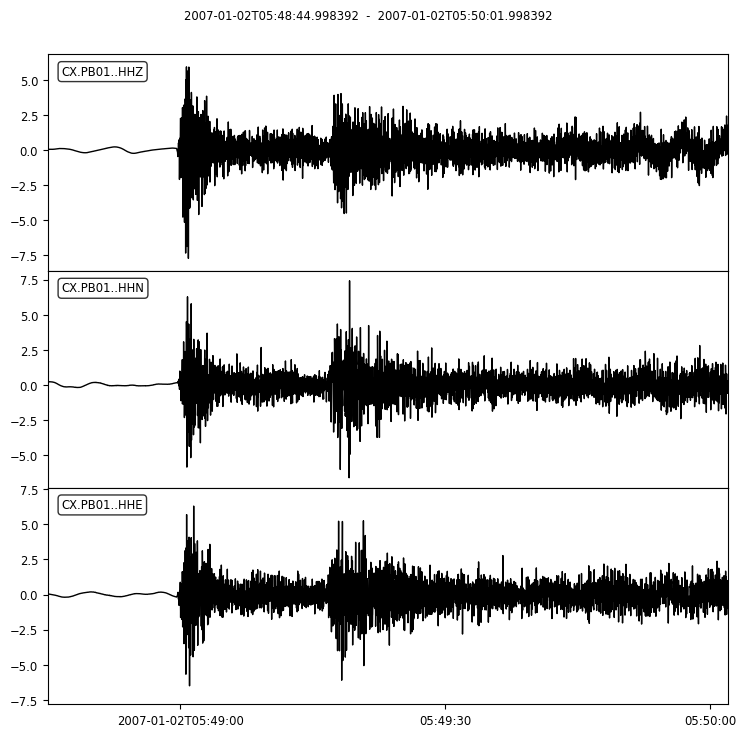

In [73]:
stream.plot();

The following code converts the obspy stream we just downloaded into a Pytorch tensor for feeding into the model. Note that for this model the tensor must be cast to `float`, otherwise it will throw an error. Also note that the `unsqueeze` function adds a dimension to the front of the tensor. This is the batch dimension, and in our case is 1 since we have only one sample.

In [74]:
X = np.stack([x.data for x in stream])
X_ = torch.tensor(X).unsqueeze(dim=0).float()
X_.shape

torch.Size([1, 3, 7701])

Run the model and remove the batch dimension for plotting later.

Since the seisbench model inherits from a pytorch nn.module, you can simply call the model with your tensor as input to use the pure pytorch model.

In [75]:
out = pnmodel(X_).squeeze()

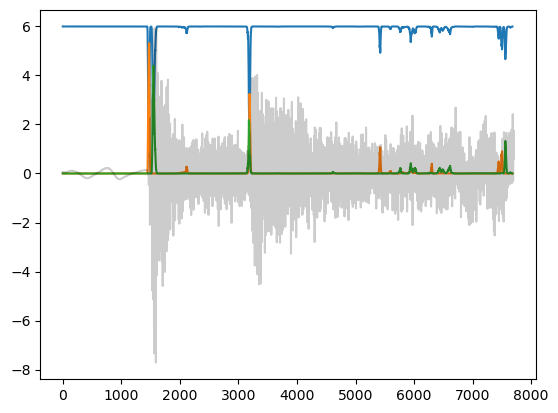

In [76]:
for a in out.detach().numpy():
    plt.plot(6*a)

plt.plot(stream[0].data, "k", alpha=0.2)

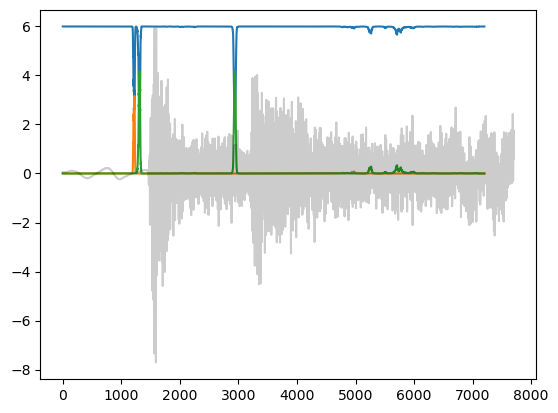

In [77]:
annots = pnmodel.annotate(stream)

for p in annots:
    plt.plot(6*p.data);

plt.plot(stream[0].data, "k", alpha=0.2);

How fast is this version compared with using the `annotate` function?

In [29]:
%timeit _ = pnmodel.annotate(stream)

12.3 ms ± 55.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%timeit _ = pnmodel(X_)

8.03 ms ± 60.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


50% faster for a 7701 sample, 3-component seismogram. What about a bigger one?

In [78]:
stream2 = client.get_waveforms(
    network="CX",
    station="PB01",
    location="*",
    channel="HH?",
    starttime=t-5,
    endtime=t+720
)

# normalize
data = np.stack([x.data for x in stream2])[np.newaxis,:,:]
data = normalize_batch(data).squeeze()
for i,normed_trace in enumerate(data):
    stream2[i].data = normed_trace

Y = np.stack([x.data for x in stream2])
Y_ = torch.tensor(Y).unsqueeze(dim=0).float()
Y_.shape

torch.Size([1, 3, 72501])

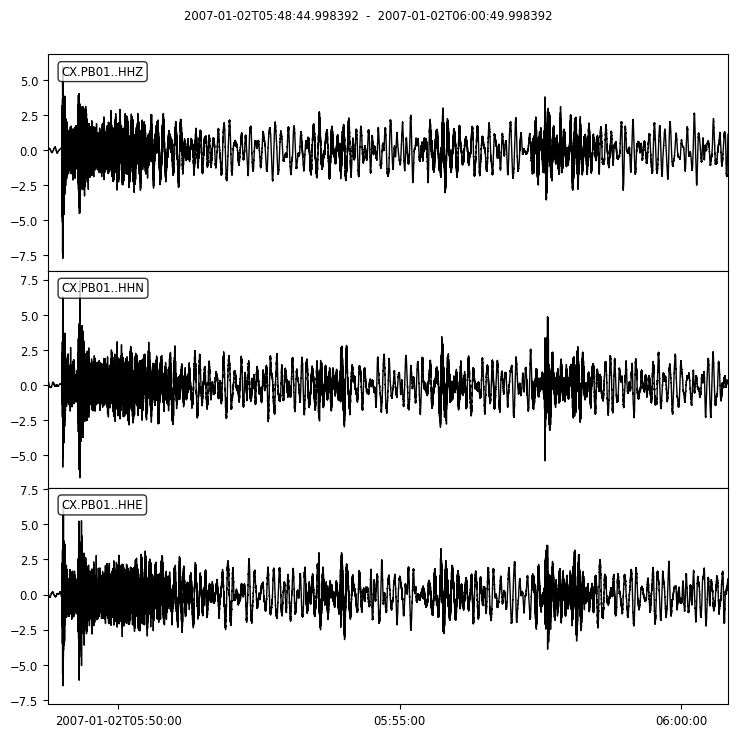

In [79]:
stream2.plot();

In [33]:
%timeit _ = pnmodel.annotate(stream2)

431 ms ± 5.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%timeit _ = pnmodel(Y_)

24.1 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


20x faster for a 72,501 sample 3-cpt seismogram!

How about larger batches?

Let's stack the same tensor 10x and run with plain pytorch.

In [17]:
Z = Y_.repeat(10,1,1)
Z.shape

torch.Size([10, 3, 72501])

In [18]:
%timeit _ = pnmodel(Z)

125 ms ± 6.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Interestingly, it's only 5x slower than a batch of 1. Perhaps it's taking advantage of the Mac M1 GPU shaders.

Text(0.5, 1.0, 'Seisbench Annotate')

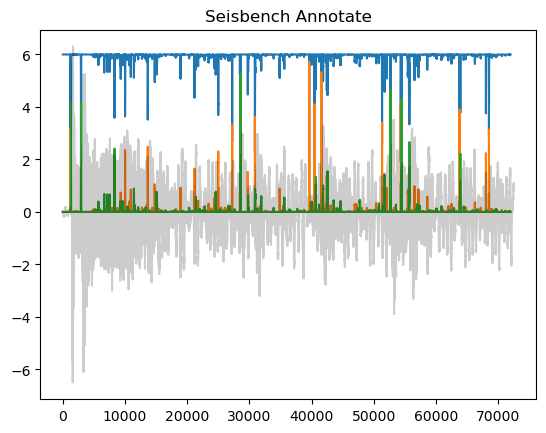

In [80]:
annots2 = pnmodel.annotate(stream2)

for p in annots2:
    plt.plot(6*p.data);

plt.plot(stream2[1].data, "k", alpha=0.2)

plt.title("Seisbench Annotate")

Text(0.5, 1.0, 'Seisbench Pytorch only')

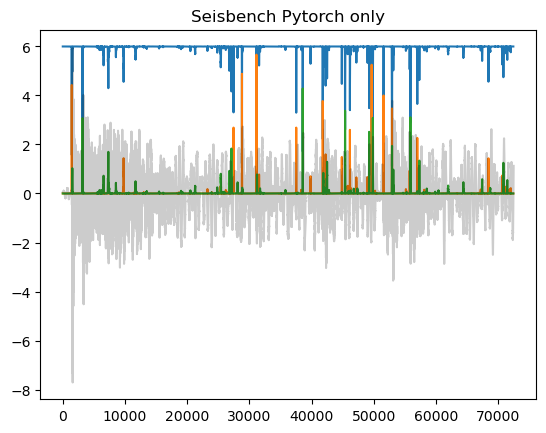

In [81]:
out2 = pnmodel(Y_).squeeze()

for a in out2.detach().numpy():
    plt.plot(6*a)

plt.plot(stream2[0].data, "k", alpha=0.2)

plt.title("Seisbench Pytorch only")

The seisbench annotate implementation applies mean-std dev normalization to the traces on a per-window basis. It also calculates phasenet using 50% overlapping windows (maybe that's why it's so slow?). For example, the default window size is 3000 samples. It would calculate phasenet predictions on the first 3000 sample window, shift right 1500 samples and calculate the next 3000 sample window, etc.

This should account for at least some of the difference in the results between the pure pytorch verison and the annotate version.